# Physical modeling

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)


## Team 3

Eleni L., Immanuela Belaineh, May Jue

## Introduction
Cellular automata have applications in various areas, including physics, biology, and many others. Here are some examples that could be described as a cellular automaton, traffic flows, forest fires, running water, liquid dissolving, and air patterns. People have been wondering whether the universe is a cellular automaton or not. If it is, then we will be able to gain new information and have a further understanding of it. Then, one might wonder if our world, which is currently well described, at our current level of understanding, by physics with particle-like objects, could be a CA at its most fundamental level. Many scholars have tried to develop theories in order to understand our world based on cellular automata. Edward Fredkin exposed what he terms the "finite nature hypothesis," which is the idea that "ultimately every quantity of physics, including space and time, will turn out to be discrete and finite." CA methods allow the simulation of a wide range of real-world effects and situations so far. 

### Import statement

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate, savefig

## Diffusion

Diffusion is the movement of a substance from an area of high concentration to an area of low concentration.
In the real world, diffusion happens in liquids and gases because their particles move randomly from place to place.
Diffusion is an important process for living things; it is how substances move in and out of cells.
Before we get to a Reaction-Diffusion model, we'll start with simple diffusion. The kernel computes the difference between each cell and the sum of its neighbors. At each time step, we compute this difference, multiply by a constant, and add it back in to the array.

In [2]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array


class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""
    
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, r=0.1):
        """Initializes the attributes.

        n: number of rows
        r: diffusion rate constant
        """
        self.r = r
        self.array = np.zeros((n, n), np.float)
        
    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c
        
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Reds')

### Complexity analysis
| Function | Big O |
| ----------- | ----------- |
| init | O(1) |
| add_cells | O(n) |
| step | O(1) |
| draw | O(1) |

The functions init() is O(1) because it is defining the variables. The function add_cells() is O(n) because for each one of the string, it is adding it on the array. For step(), it is calculating the step with the given equation. For the draw(), it is O(1) because it is calling the draw_array function.

### Examples
Here's a simple example starting with an "island" of material in the middle.

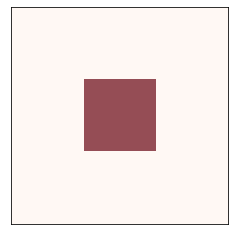

In [3]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
diff.draw()

And here's how it behaves over time: the "material" spreads out until the level is equal on the whole array.

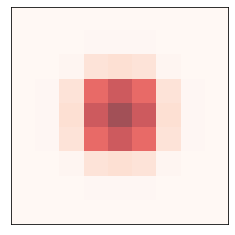

In [ ]:
diff.animate(frames=20, interval=0.1)

In [ ]:
from utils import three_frame

diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
three_frame(diff, [0, 5, 10])

savefig('figs/chap07-1')

## Reaction-Diffusion

Now we'll add a second material in the middle of the array and let them interact. As the two materials diffuse over time that makes them interact with each other is the reaction. The following function helps with setting up the initial conditions.

In [ ]:
def add_island(a, height=0.1):
    """Adds an island in the middle of the array.
            
    height: height of the island
    """
    n, m = a.shape
    radius = min(n, m) // 20
    i = n//2
    j = m//2
    a[i-radius:i+radius, j-radius:j+radius] += height

### Complexity Analysis
| Function | Big O |
| ----------- | ----------- |
| add_island | O(1) |

For the RD model, we have two arrays, one for each chemical and two concentrations.

Following [Sims](http://www.karlsims.com/rd.html), I'm using a kernel that includes the diagonal elements.  They have lower weights because they are farther from the center cell. The Laplacian is performed with a 3x3 convolution with center weight -1, adjacent neighbors .2, and diagonals .05. The grid is initialized with A=1, B=0, and a small area is seeded with B=1.

$$ Kernel = \begin{pmatrix}
.05 & .2 & .05 \\
.2 & -1 & .2 \\
.05 & .2 & .05
\end{pmatrix}$$ 

The `step` function computes these functions:

$\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $

$\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $

where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.

The grid is repeatedly updated using the following equations to update the concentrations
of A and B in each cell, and model the behaviors described above.

$ A' = A + (\Delta A = r_a \nabla^2 A - AB^2 + f (1-A))  \Delta t $

$ B' = B + (\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B)  \Delta t $


In [ ]:
class ReactionDiffusion(Diffusion):
    """Reaction-Diffusion Cellular Automaton."""

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    def __init__(self, n, params, noise=0.1):
        """Initializes the attributes.

        n: number of rows
        params: tuple of (Da, Db, f, k)
        """        
        self.params = params
        self.array1 = np.ones((n, n), dtype=float)
        self.array2 = noise * np.random.random((n, n))
        add_island(self.array2)
        
    def step(self):
        """Executes one time step."""
        A = self.array1
        B = self.array2
        ra, rb, f, k = self.params

        options = dict(mode='same', boundary='wrap')

        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        reaction = A * B**2
        #ra, rb are the diffusion rates
        # cA, cB are teh Laplacian 2d funstions
        # reaction is the chance that on "molecule" of A and 2 "molecules" of B will meet
        # f(1-A) is the feed which is the rate that we add A.
        # (f+k)* B shows the kill rate which is the rate that B is removed
        self.array1 += ra * cA - reaction + f * (1-A) 
        self.array2 += rb * cB + reaction - (f+k) * B
        
    def loop100(self):
        self.loop(100)
        
    def draw(self):
        """Draws the cells."""
        options = dict(interpolation='bicubic', 
                       vmin=None, vmax=None)
        draw_array(self.array1, cmap='Reds', **options)
        draw_array(self.array2, cmap='Blues', **options)

### Explaning the step function
ra, rb are the diffusion rates
cA, cB are teh Laplacian 2d functions
reaction is the chance that on "molecule" of A and 2 "molecules" of B will meet
f(1-A) is the feed which is the rate that we add A.
f+k)* B shows the kill rate which is the rate that B is removed

### Complexity analysis
Function     |  Big  O      
 ----------- | ------------------- 
 init        | O(1)        
 step        | O(n<sup>2</sup>)    
 loop100     | O(n<sup>2</sup>)    
 draw        | O(1)       


The fuction init() is O(1) as it is assigning values, and calls the function add_islands(). For the step() function it first assigns values and then calculates the cA, cB, and reaction. For loop100() it is O(1) because it calls self.loop(), which controls how many times . For the draw(), it is O(1) because it is calling the draw_array function.

The viewer for the CA shows both arrays with some transparency, so we can see where one, the other, or both, levels are high.

Unlike previous CAs, the state of each cell is meant to represent a continuous quantity, so it is appropriate to interpolate.

Note that `draw` has to make copies of the arrays because `step` updates the arrays in place.

### Examples
Here's an example using `params3`, which yields blue dots that seem to undergo mitosis.

In [ ]:
params1 = 0.5, 0.25, 0.035, 0.057   # pink spots and stripes
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd = ReactionDiffusion(n=100, params=params1)
rd.draw()

Here's a random starting condition with lots of A, a sprinkling of B everywhere, and an island of B in the middle.

In [ ]:
rd.animate(frames=50, step=rd.loop100)


I'll use the following function to generate figures using different parameters. The following function calls the class Reaction diffucion multiple times using different parameters.


In [ ]:
def make_rd(f, k, n=100):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params)
    return rd

The following parameters yield pink stripes and spots on a blue background:

In [ ]:
from utils import three_frame

def plot_rd(f, k, filename):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(100, params)

    three_frame(rd, [1000, 2000, 4000])
    
    savefig(filename)
    
plot_rd(0.035, 0.057, 'figs/chap07-2')

The following parameters yield blue stripes on a pink background.

In [ ]:
plot_rd(0.055, 0.062, 'figs/chap07-3')

The following parameters yield blue dots on a pink background

In [ ]:
plot_rd(0.039, 0.065, 'figs/chap07-4')

## Percolation

It is a process where liquid flow through semi-porous material and we can see this happening in the example of when we dip the tip of a paper in water. This also happen in nature during rock formation but they can also be used to study epidemics and networks of electrical resistors.

#### Percolation Model

In the percolation model, each cell is porous with probability `p` or non-porous with the probability `1-p`.  We start with a row of wet cells at the time.  During each time step, a cell becomes wet if it is porous and at least one neighbor is wet (using a 4-cell neighborhood).  For each value of `p` we compute the probability that water reaches the bottom row.

Porous cells have state `1` and wet cells have state `5`, so if a cell has a wet neighbor, the sum of the neighbors will be `5` or more.

#### Code
The goal of the following code is to iterate the steps to simulate percolation. We start with a row of wet cells at the top follow by a random array of porus and non-porus cells based on the probablity `q`. We will iterate through to cells and if the cells have any wet neighbor, the cell itself will become a wet cell. This will continue until we reach the bottom row or if there is no longer any changes.

In the cell below, we can see that our Kernel is set up to have 1 to the top, bottom, left, and right but not the diagonal of the center because each cell will not be impacted by the diagonals.
The self.array is the state of each cell. In the step function, we can see that the array is updated when the neighbor is checked and the sum is 5 or greater. The cell then become 5, indicating that it is a wet cell.
The num_wet add the total number of wet cell. This is so that we will know if there is any new wet cell in each iteration or if we have reach a poit where there is no changes.
https://www2.cs.duke.edu/courses/compsci307d/fall20/assign/03_simulation/PercolationCA.pdf


In [ ]:
from scipy.signal import correlate2d
from Cell2D import Cell2D


class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, q=0.5):
        """Initializes the attributes.

        n: number of rows
        q: probability of porousness
        """
        self.q = q
        self.array = np.random.choice([1, 0], (n, n), p=[q, 1-q])
        
        # fill the top row with wet cells
        self.array[0] = 5

    def step(self):
        """Executes one time step."""
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5
        
    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)
    
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Blues', vmax=5)

#### Big O
The Big O of this section of the code is O(n<sup>2</sup>) . The function   `__init__` has the Big O if O(n<sup>2</sup>) since it is creating random numbers for evry cells in a matrix of `n` by `n`. And in the step function, it is also O(n<sup>2</sup>) since it is going through everything in the matrix `n` by `n` to calculate if it will become wet.

Here an example that shows the first three time steps.

In [ ]:
n = 10
q = 0.7
np.random.seed(18)
perc = Percolation(n, q)

three_frame(perc, [1, 1, 1])

savefig('figs/chap07-5')

Changing the `q` to a lower number

In [ ]:
n = 10
q1 = 0.2
np.random.seed(18)
perc1 = Percolation(n, q1)

three_frame(perc1, [1, 1, 1])

savefig('figs/chap07-5')

As we can see above, the cells is not making many more changes after the second iteration because the porus cells are blocked. <br><br>
Changing `q` to a higher number

In [ ]:
n = 10
q2 = 0.9
np.random.seed(18)
perc2 = Percolation(n, q2)

three_frame(perc2, [1, 1, 1])

savefig('figs/chap07-5')

In the examples above, we added some changes to `q` so that we can see that the non-porus cells are white and the porus are light blue. The wet cells are dark blue. If we were to change the `q` to a lower number, there will be less wet cells since there are more non-porus cells. If we change it to a higher number, there will we more wet cells with less non-porus cells. The higher the `q` is, the faster the wet cells travel down the matrix as there is nothing to stop it or slow it down.<br>
`test_perc` runs a percolation model and returns `True` if water reaches the bottom row and `False` otherwise. In each iteration, the function is calling the function `step()` to check the neighbor and if this cell will become wet. Then it check if the bottom row is wet, if so, it will return True. It also check to see if there are any new wet cells, if there is none, it means that there is no longer any changes can be made, thus it stop and return false.

In [ ]:
def test_perc(perc):
    """Run a percolation model.
    
    Runs until water gets to the bottom row or nothing changes.
    
    returns: boolean, whether there's a percolating cluster
    """
    num_wet = perc.num_wet()

    while True:
        perc.step()

        if perc.bottom_row_wet():
            return True
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False

        num_wet = new_num_wet

### Big O
The Big O of this function is O(n<sup>2</sup>). In the best case, this code will be constatn O(1) because it means that there is non-porus cells covering the whole second row and it can not advance anymore.<br>
The complexicity is O(1/2n<sup>2</sup>), thus the Big O is B(n<sup>2</sup>).<br> The image below shows the the worst case for this function where it would non-porus cells that would force the wet cells to take as long as possible to reach the bottom. This shows O(1/2n<sup>2</sup>) because it will run half of n<sup>2</sup> times as half of the other cells are non-porus. <br> ![](fig/percolation.png)

Run a small example. 

In [ ]:
np.random.seed(18)
perc = Percolation(n, q)
test_perc(perc)

And here's the animation

In [ ]:
np.random.seed(18)
perc = Percolation(n, q)
perc.animate(frames=12, interval=0.3)

For a given `q` we can estimate the probability of a percolating cluster by running several random configurations.
This means that we are testing which point of `q` can water reach the bottom. We will pass in differnt value for `q` and create 100 different iteration to see how many times will it reach the bottom based on the `q` value. 

In [ ]:
def estimate_prob_percolating(n=100, q=0.5, iters=100):
    """Estimates the probability of percolating.
    
    n: int number of rows and columns
    q: probability that a cell is permeable
    iters: number of arrays to test
    
    returns: float probability
    """
    t = [test_perc(Percolation(n, q)) for i in range(iters)]
    return np.mean(t)

At `q=0.55` the probability is low.

In [ ]:
fraction = estimate_prob_percolating(q=0.55)
print(fraction)

At `p=0.65` the probability is high. Eventhough we only increased by .05, the change is very rapid, thus we know that the critical value is around `0.6`

In [ ]:
fraction = estimate_prob_percolating(q=0.6)
print(fraction)

At `p=0.65` the probability is high.

In [ ]:
fraction = estimate_prob_percolating(q=0.65)
print(fraction)

We can search for the critical value by random walk: if there's a percolating cluster, we decrease `q`; otherwise we increase it.

The path should go to the critical point and wander around it.
The critical point we are looking for here can be compare to water freezing point where it change from liquid to solid. But, in our case with critical point, we want ot know at which number of `q`, will the cluster happen

In [ ]:
def find_critical(n=100, q=0.6, iters=100):
    """Estimate q_crit by random walk.
    
    returns: list of q that should wander around q_crit
    """
    qs = [q]
    for i in range(iters):
        perc = Percolation(n, q)
        if test_perc(perc):
            q -= 0.005
        else:
            q += 0.005
        qs.append(q)
    return qs

Let's see whether the critical value depends on the size of the grid.

With `n=50`, the random walk wanders around 0.59.

In [ ]:
%time qs = find_critical(n=50, iters=1000)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Larger values of `n` don't seem to change the critical value.

In [ ]:
%time qs = find_critical(n=100, iters=200)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

In [ ]:
%time qs = find_critical(n=200, iters=40)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

In [ ]:
%time qs = find_critical(n=400, iters=10)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

We can see from the above example that the size does not have any affect on the critical point. From the `n` range of 50-400, the critical point reamin at around 0.59

## Fractals

Near the critical point, the cluster of wet cells forms a fractal.  We can see that visually in these examples:

In [ ]:
np.random.seed(22)
perc1 = Percolation(n=100, q=0.6)
flag = test_perc(perc1)
print(flag)
perc1.draw()

In [ ]:
np.random.seed(22)
perc2 = Percolation(n=200, q=0.6)
flag = test_perc(perc2)
print(flag)
perc2.draw()

In [ ]:
np.random.seed(22)
perc3 = Percolation(n=300, q=0.6)
flag = test_perc(perc3)
print(flag)
perc3.draw()

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
perc1.draw()

plt.subplot(1, 3, 2)
perc2.draw()

plt.subplot(1, 3, 3)
perc3.draw()

plt.tight_layout()
savefig('figs/chap07-6')

To measure fractal dimension, let's start with 1D CAs.

In [ ]:
from Cell1D import Cell1D, draw_ca

Here's one rule that seems clearly 1D, one that is clearly 2D, and one that we can't obviously classify.

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
draw_ca(20)

plt.subplot(1, 3, 2)
draw_ca(50)

plt.subplot(1, 3, 3)
draw_ca(18)

plt.tight_layout()
savefig('figs/chap07-7')

The following function creates a 1D CA and steps through time, counting the number of on cells after each time step.

Fractals are complex paterns that are formed from simple patterns because of a large number of reppition. For instance a snowflake is considered a fractal because starting from a simple triangle each side can be divided to become 4 sided and each four sides will become four as well. This can lead to 3 * 4^n sides. As n (how many times the recursion itterates) increases the image becomes more complex. The volume of the pattern remains the same, only the surface area changes. 


![](fig/Fractals.gif "Fractals")
![](fig/Triangle.gif "Triangle")

In [ ]:
def count_cells(rule, n=500):
    """Create a 1-D CA and count cells.
    
    rule: int rule number
    n: number of steps
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

This function plots the results, comparing the rate of cell growth to `size` and `size**2`.

And it uses linregress to estimate the slope of the line on a log-log scale.

In [ ]:
from scipy.stats import linregress

def test_fractal(rule, ylabel='Number of Cells'):
    """Compute the fractal dimension of a rule.
    
    rule: int rule number
    ylabel: string
    """
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)

    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(steps, steps2, label='d=2', **options)
    plt.plot(steps, cells, label='rule=%d' % rule)
    plt.plot(steps, steps, label='d=1', **options)

    decorate(xscale='log', yscale='log',
             xlabel='Time Steps',
             ylabel=ylabel,
             xlim=[1, 600], loc='upper left')

    for ys in [cells]:
        params = linregress(np.log(steps), np.log(ys))
        print(params[0])

The linear rule has dimension close to 1.

In [ ]:
test_fractal(20)

The triangular rule has dimension close to 2.

In [ ]:
test_fractal(50)

And the Sierpinski triangle has fractal dimension approximately 1.57

In [ ]:
test_fractal(18)

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
test_fractal(20)

plt.subplot(1, 3, 2)
test_fractal(50, ylabel='')

plt.subplot(1, 3, 3)
test_fractal(18, ylabel='')

savefig('figs/chap07-8')

Mathematically, the fractal dimension is supposed to be:

In [ ]:
np.log(3) / np.log(2)

## Fractals in percolation models

We can measure the fractal dimension of a percolation model by measuring how the number of wet cells scales as we increase the size of a bounding box.

The following function takes a percolation model that has run to completion.  It computes bounding boxes with sizes from 10 up to `n-1`, positioned in the center of the array.

For each bounding box it counts the number of wet cells.

In [ ]:
from scipy.stats import linregress

def plot_perc_scaling(sizes, q):
    res = []
    for size in sizes:
        perc = Percolation(size, q)
        if test_perc(perc):
            num_filled = perc.num_wet() - size
            res.append((size, size**2, num_filled))
        
    sizes, cells, filled = zip(*res)
    
    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(sizes, cells, label='d=2', **options)
    plt.plot(sizes, filled, '.', label='filled')
    plt.plot(sizes, sizes, label='d=1', **options)
    
    decorate(xlabel='Array Size',
                     ylabel='Cell Count',
                     xscale='log', xlim=[9, 110], 
                     yscale='log', ylim=[9, 20000],
                     loc='upper left')
    
    for ys in [cells, filled, sizes]:
        params = linregress(np.log(sizes), np.log(ys))
        print(params[0])

If we plot the number of cells versus the size of the box on a log-log scale, the slope is the fractal dimension.

When `q` is near the critical point, the fractal dimension of the wet cells is usually between 1.8 and 2.0, but it varies from one run to the next.

In [ ]:
sizes = np.arange(10, 101)
plot_perc_scaling(sizes, q=0.59)

savefig('figs/chap07-9')

**Exercise:** In Chapter 7 we showed that the Rule 18 CA produces a fractal.
Can you find other rules that produce fractals?  For each one,
estimate its fractal dimension.

Note: the `Cell1D` object in `Cell1D.py` does not wrap around from the left edge to the right, which creates some artifacts at the boundaries.  You might want to use `Wrap1D`, which is a child class of `Cell1D` that wraps around.  It is also defined in `Cell1D.py`.

**Exercise:** In 1990 Bak, Chen and Tang proposed a cellular automaton that is
an abstract model of a forest fire.  Each cell is in one of three
states: empty, occupied by a tree, or on fire.

The rules of the CA are:

* An empty cell becomes occupied with probability $p$.

* A cell with a tree burns if any of its neighbors
  is on fire.

* A cell with a tree spontaneously burns, with
  probability $f$, even if none of its neighbors is on fire.

* A cell with a burning tree becomes an empty cell in the next
  time step.

Write a
program that implements it.  You might want to inherit from `Cell2D`.
Typical values for the parameters are
$p=0.01$ and $f=0.001$, but you might want to experiment with other
values.

Starting from a random initial condition, run the CA until it reaches
a steady state where the number of trees no longer increases or
decreases consistently.  

In steady state, is the geometry of the forest fractal?
What is its fractal dimension?

### Learning Outcomes

**Eleni L.** -  I engaged with physical modeling, cellular automata and analyzed the complexity of the functions on those sections. I became more knowledgeable about the topics of Diffusion and Reaction, and how the change in the concentration is calculated while reaction and diffusion is happening. I found the applications extremely interesting, as it is important in both the molecular, cellular, and daily life. Last but not least, I got used to GitHub and how to work on GitHub.

**Imma** - I got to learn about fractals and the different patterns in nature that are formed by the use of fractals. I also learned more about how to avoid merge conflicts in Jupiter notebooks by working on the same document since different images were rendered when each of us ran the notebooks and that caused some errors. Additionally, I spent quite some time thinking about complexity with my team, I would say that this assignment allowed me to broaden my understanding of complexity.

**May** - I learned about complexity and what physical modeling is. I also learned about the diffusion models but since I focused mostly on the percolation section, I have a very deep understanding of the purpose of the model and how it works. We can use percolation models outside of just liquid as they can be used to also study epidemics and network electron resistors.

### Conclusion

Cellular automata have been an important topic for complexity analysis. While it has multiple applications in various areas, some of them include diffusion, reaction, and fractal patterns that appear in nature. Many times people have described natural phenomena on the cellular level, but people have been wondering whether the universe can be described as a cellular automaton or not. In our project: 
1. We understood more about how some physical modelings work
2. We can represent real-life applications with the use of cellular automata
3. We analyzed the function provided and examined the complexity
4. We got more insight into how simple patterns can make up complex Level 4 models through recursive division such as in fractals.

### Resources Used

<cite> Cellular Automata for Physical Modelling (n.d.). Retrieved November 20, 2020, from https://tomforsyth1000.github.io/papers/cellular_automata_for_physical_modelling.html </cite>

<cite> Chopard, B. (n.d.). Cellular Automata and lattice Boltzmann modeling of physical systems. Retrieved November 19, 2020, from http://cui.unige.ch/~chopard/FTP/Cours/ac-lb.pdf </cite>

<cite> Crutchfield, J. P. (1993). The Calculi of Emergence: Computation, Dynamics, and Induction. Retrieved November 19, 2020, from http://csc.ucdavis.edu/~cmg/papers/CalcEmerg.pdf </cite>

<cite> Fractal. (2020, October 31). Retrieved November 20, 2020, from https://en.wikipedia.org/wiki/Fractal </cite>

<cite> Haggit, C. (2011, April 26)."How Fractals Work".
HowStuffWorks.com. From https://science.howstuffworks.com/math-concepts/fractals.htm </cite>

<cite> Gunther, S.(2020, May 7). “14 Amazing Fractals Found in Nature”. Treehugger. From 
https://www.treehugger.com/amazing-fractals-found-in-nature-4868776 </cite>

<cite> Khanjary, M. Sabaei, M.  Meybodi, M. (2015). A Percolation Algorithm Based on Cellular Automata. From https://www2.cs.duke.edu/courses/compsci307d/fall20/assign/03_simulation/PercolationCA.pdf </cite>

<cite> Mathema GIF [Digital image]. (n.d.). Retrieved November 19, 2020, from https://www.pinterest.com/pin/461970874249211723/ </cite>

<cite> Menke, H.(2017, December 6). Animated Koch Snowflake. Stackexchange. From https://tex.stackexchange.com/questions/404925/animated-koch-snowflake </cite>

<cite>  MITK12Videos. (2015, June 11). What Is A Fractal (and what are they good for)?[video file]. From https://www.youtube.com/watch?v=WFtTdf3I6Ug </cite>

<cite> Pearce, J. L. (n.d.). On Complexity. Retrieved November 20, 2020, from https://runestone.academy/runestone/books/published/complex/index.html </cite>

<cite>Sims, K. (2013). Reaction-Diffusion Tutorial. Retrieved November 20, 2020, from http://www.karlsims.com/rd.html </cite>

<cite> Stiffler, L. (2012, January 3). The Porous Road Less Traveled. From https://www.sightline.org/2012/01/03/the-porous-road-less-traveled/ </cite>

<cite> What is mitosis? (2017, May 17). Retrieved November 20, 2020, from https://www.yourgenome.org/facts/what-is-mitosis </cite>
